In [2]:
from CANCER import *


In [3]:
import torch_geometric.utils as TGUtils
import torch_geometric.transforms as TGTransforms
import networkx as nx
from matplotlib import pyplot as plt

class DataShower:
    def __init__(self):
        None
    @classmethod
    def show_dataset(self, dataset):
        print(f'Dataset: {dataset}')
        print('-------------------')
        
        print(f'Number of graphs: {len(dataset)}')
        print(f'Number of nodes: {dataset[0].x.shape[0]}')
        print(f'Number of features: {dataset.num_features}')
        print(f'Numer of edge attr: {dataset.edge_attr}')
        print(f'Number of classes: { dataset.num_classes}')
    
    @classmethod
    def show_y_number(self, dataset):
        y_dict = dict()
        for y in dataset.y:
            if y.item() in y_dict.keys():
                y_dict[y.item()] += 1
            else:
                y_dict[y.item()] = 1
        li = sorted(y_dict.items(), key=lambda x: x[1], reverse=True)
        print(li)
        li = [(y, num / dataset.y.shape[0]) for y, num in li]
        print(li)
    
    
    @classmethod
    def network_node(self, G):
        zero_degree_nodes = [node for node in G.nodes() if G.degree(node) == 0]
        zero_indegree_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
        zero_outdegree_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
        path_start_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.degree[node] != 0]
        path_end_nodes = [node for node in G.nodes() if G.out_degree(node) == 0 and G.degree[node] != 0]
        
        print('0-Degree  nodes#: ', len(zero_degree_nodes))
        print("0-Indegree node#:", len(zero_indegree_nodes))
        print("0-Outdegre node#:", len(zero_outdegree_nodes))
        print(f"path 시작 노드: {len(path_start_nodes)}개 {path_start_nodes}")
        print(f"path 종결 노드: {len(path_end_nodes)}개 {path_end_nodes}")
    
    @classmethod
    def network_show(self, G, mapping):
        nx.relabel_nodes(G, mapping = mapping, copy=False)
        d = dict(G.degree)
        center = [key for key, degree in enumerate(d.values()) if degree != 0]
        bound = [key for key, degree in enumerate(d.values()) if degree == 0]
        pos = nx.shell_layout(G, [center, bound], scale=10)
        label_pos = {mapping[key] : value for key, value in pos.items()}
        # print(label_pos)
        nx.draw_networkx(
            G, pos=label_pos, 
            node_color='r', 
            node_size=[v * 50 for v in d.values()],
            edge_color='b',width=0.5,
            font_size=5
        )
    @classmethod
    def show_reduced_network(self, G, mapping):
        nx.relabel_nodes(G, mapping = mapping, copy=False)
        d = dict(G.degree)
        pos = nx.circular_layout(G)
        nx.draw_networkx(
            G, pos=pos, 
            node_color='r', 
            node_size=[v * 50 for v in d.values()],
            edge_color='b',width=0.5,
            font_size=5
        )
        
        
            

In [4]:
class DatasetTransformer:
    @classmethod
    def to_graph(self, dataset):
        selected = dataset[0]
        return TGUtils.to_networkx(selected, to_undirected=False)
    
    @classmethod
    def to_linked_graph(self, dataset):
        G = DatasetTransformer.to_graph(dataset)
        G.remove_nodes_from(list(nx.isolates(G)))
        return G
    
    @classmethod
    def get_largest_and_drop(self, dataset, mapping):
        import  queue
        import  math
        G = DatasetTransformer.to_graph(dataset)

        roots = [root for root in G.nodes() if G.in_degree(root) == 0]
        
        queue = queue.Queue()
        connected_nodes = [[] for _ in range(len(roots))]
        for idx, root in enumerate(roots):
            visited = dict()
            
            queue.put(root)
            connected_nodes[idx].append(root)
            visited[root] = True
            while not queue.empty():
                cur = queue.get()
                for node in G.neighbors(cur):
                    if node not in visited:
                        queue.put(node)
                        visited[node] = True
                        connected_nodes[idx].append(node)
        
        important = [connection for connection in connected_nodes if len(connection) > 1]
        row_len = 3
        col_len = math.ceil(len(important) / row_len)
        fig, axs = plt.subplots(row_len, col_len, figsize=(8 * col_len, 6 * row_len))
        
        for idx, nodes in enumerate(important):
            subgraph = G.subgraph(nodes)
            subgraph = subgraph.to_directed()
            nx.relabel_nodes(subgraph, mapping = mapping, copy=False)
            pos = nx.planar_layout(subgraph)
        
            nx.draw_networkx(
                subgraph, pos=pos, 
                # node_color='r', 
                node_size=300,
                arrowsize=10,
                # edge_color='b',width=0.5,
                font_size=15,
                ax=axs[idx % row_len, idx // row_len]
            )
        plt.tight_layout()
        plt.show()
        # nx.draw(subgraph, with_labels=True)
        # print(subgraph)


In [5]:
class DatasetComparer:
    def __init__(self):
        None
    @classmethod
    def compare_edge(self, dataset_list):
        dataset_paths_weight = [
            set(
                [
                    (start.item(), end.item(), value.item()) 
                    for start, end, value in zip(dataset[0].edge_index[0], dataset[0].edge_index[1], dataset[0].edge_attr)
                ]
            )
            for dataset in dataset_list
        ]
        dataset_paths = [
            set(
                [
                    (start.item(), end.item()) 
                    for start, end in zip(dataset[0].edge_index[0], dataset[0].edge_index[1])
                ]
            )
            for dataset in dataset_list    
        ]
    
        for idx, edge in enumerate(dataset_paths):
            print(f'dataset{idx} edge # : {len(edge)} {edge}')
        
        path_similarity_matrix = [
            [
                len(base_set.intersection(comp_set)) / len(base_set) for comp_set in dataset_paths
            ]for base_set in dataset_paths
        ]
        path_similarity_matrix_weight = [
            [
                len(base_set.intersection(comp_set)) / len(base_set) for comp_set in dataset_paths_weight
            ]for base_set in dataset_paths_weight
        ]

        multi_intersection = dataset_paths[0]
        for idx, edge in enumerate(dataset_paths):
            multi_intersection = multi_intersection.intersection(edge)
            for similarity in path_similarity_matrix[idx]:
                print("%0.4f" % similarity, end=' ')
            print()
        print()
        
        for idx, edge in enumerate(dataset_paths_weight):
            for similarity in path_similarity_matrix_weight[idx]:
                print("%0.4f" % similarity, end=' ')
            print()
        print(f'multi_intersection edge # : {len(multi_intersection)} {multi_intersection}')
        


In [9]:
Full = MyDataSet(
            [NLabel.FULL.filename],
                [
                    ELabel.CANCER, 
                    ELabel.BREAST_CANCER,
                    ELabel.COLORECTAL_CANCER,
                    ELabel.RENAL_CELL_CARCINOMA,
                    ELabel.GILOMA,
                    ELabel.ENDOMETRIAL_CANCER
                ],
                detail=False, 
                drop_y_threshold= 200
            )

BreastCancer = MyDataSet([NLabel.BRAC_TCGA.filename], [ELabel.BREAST_CANCER], drop_y_threshold= 1)
Broad = MyDataSet([NLabel.CCLE_BROAD_2019.filename], [ELabel.CANCER], drop_y_threshold= 1)
Coadread = MyDataSet([NLabel.COADREAD_TCGA_PAN_CAN_ATLAS_2018.filename], [ELabel.COLORECTAL_CANCER], drop_y_threshold= 1)
Kirc = MyDataSet([NLabel.KIRC_TCGA.filename], [ELabel.RENAL_CELL_CARCINOMA], drop_y_threshold= 1)
Giloma = MyDataSet([NLabel.LGG_TCGA.filename], [ELabel.GILOMA], drop_y_threshold= 1)
Ucec = MyDataSet([NLabel.UCEC_TCGA_PAN_CAN_ATLAS.filename], [ELabel.ENDOMETRIAL_CANCER], drop_y_threshold= 1)

Full_dataset = Full.make_dataset_onehot_column()
DataShower.show_y_number(Full_dataset)

BreastCancer_dataset = BreastCancer.make_dataset()
Broad_dataset = Broad.make_dataset()
Coadread_dataset = Coadread.make_dataset()
Kirc_dataset = Kirc.make_dataset()
Giloma_dataset = Giloma.make_dataset()
Ucec_dataset = Ucec.make_dataset()

# DataShower.show_y_number(Full_dataset)

DatasetComparer.compare_edge(
    [
        BreastCancer_dataset, 
        Giloma_dataset, 
        Broad_dataset, 
        Coadread_dataset, 
        Kirc_dataset, 
        Ucec_dataset
    ]
)

DataShower.show_y_number(BreastCancer_dataset)
DataShower.show_dataset(BreastCancer_dataset)

yset  6
yset  14
yset  122
yset  3
yset  1
yset  6
yset  3
[(3, 3319), (4, 817), (5, 595), (0, 565), (2, 425), (1, 200)]
[(3, 0.5605472048640432), (4, 0.1379834487417666), (5, 0.10048978213139673), (0, 0.09542307042729269), (2, 0.07177841580814051), (1, 0.03377807802736024)]
dataset0 edge # : 54 {(174, 69), (59, 116), (116, 174), (64, 84), (69, 68), (116, 6), (29, 99), (108, 60), (1, 116), (6, 60), (99, 81), (84, 68), (128, 68), (6, 69), (29, 129), (66, 93), (116, 170), (69, 55), (174, 13), (136, 26), (99, 108), (174, 141), (81, 99), (86, 147), (116, 69), (96, 72), (35, 68), (128, 55), (26, 68), (84, 55), (129, 29), (114, 129), (78, 56), (6, 13), (53, 70), (6, 141), (174, 70), (40, 75), (129, 114), (56, 78), (86, 91), (36, 78), (108, 70), (40, 39), (35, 55), (78, 29), (80, 93), (26, 55), (157, 35), (93, 96), (55, 109), (6, 70), (174, 60), (53, 60)}
dataset1 edge # : 30 {(113, 87), (87, 80), (64, 84), (80, 68), (58, 141), (42, 35), (84, 68), (84, 126), (66, 93), (22, 68), (22, 126), (86

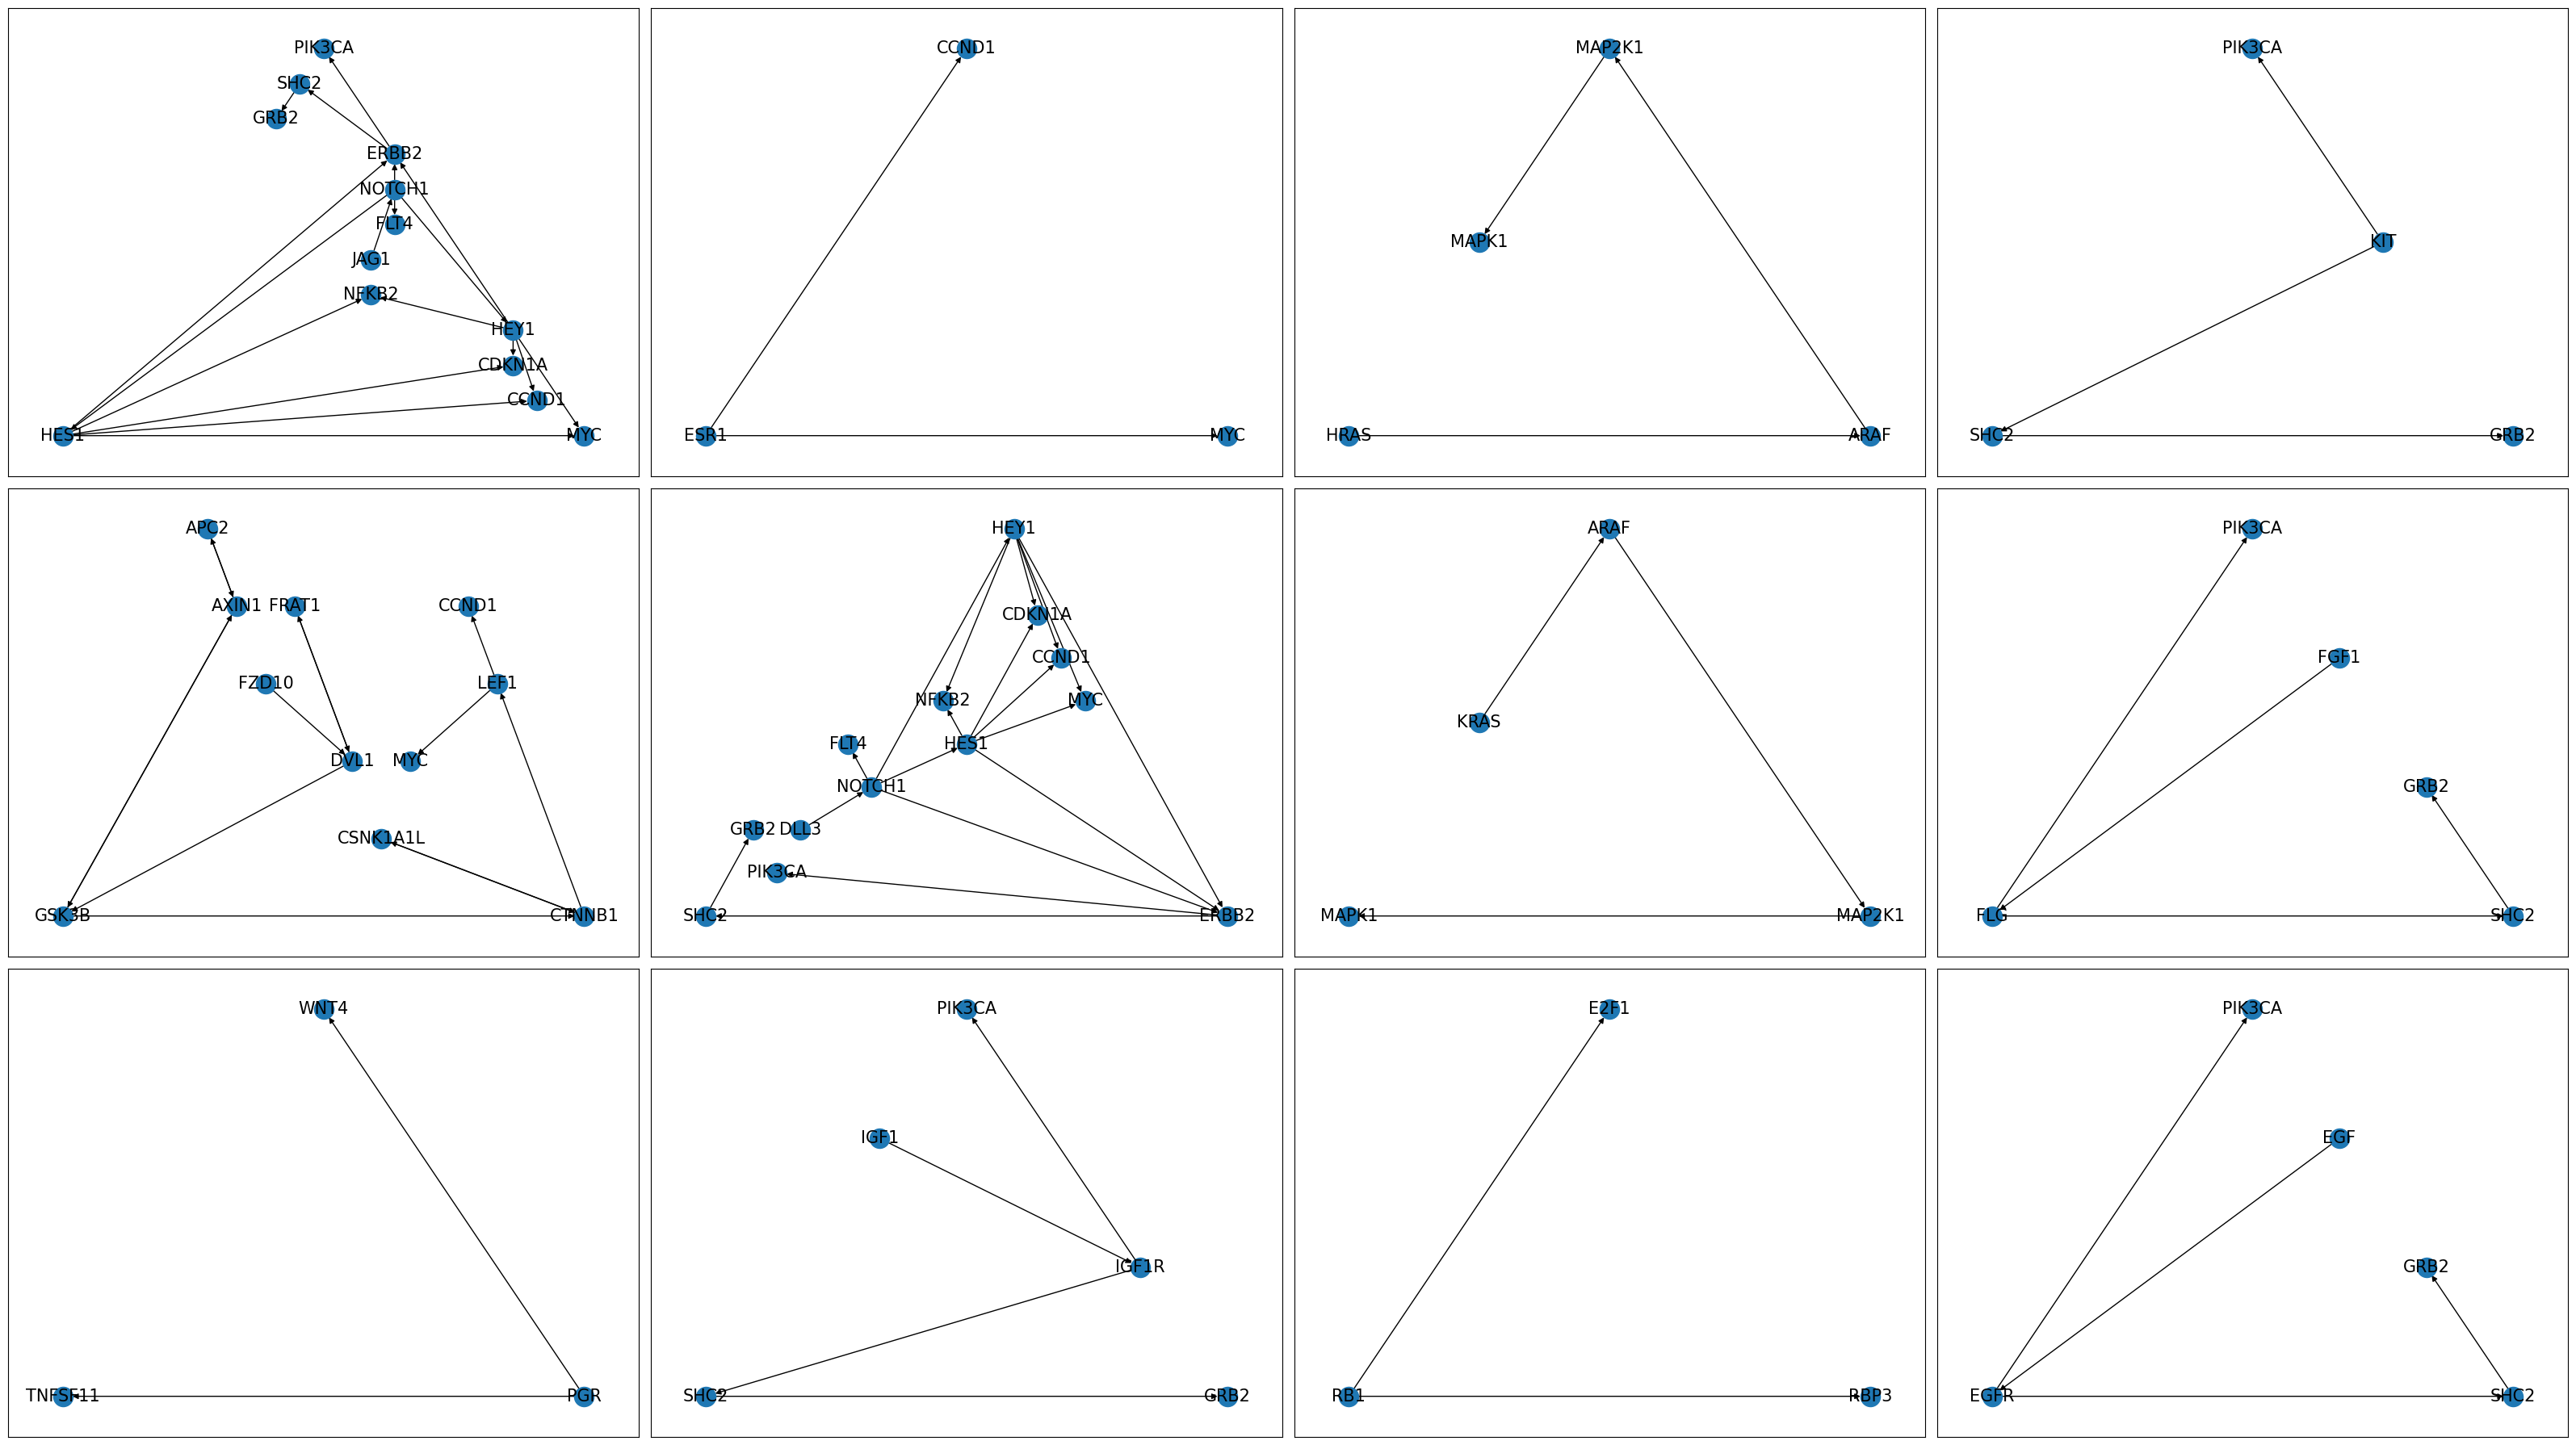

In [7]:
lcc = DatasetTransformer.get_largest_and_drop(BreastCancer_dataset, BreastCancer.idx2col)


In [ ]:
# 모든 경로 종류 찾기
all_paths = []
for source in G.nodes():
    for target in G.nodes():
        if source != target:
            paths = list(nx.all_simple_paths(G, source=source, target=target))
            all_paths.extend(paths)

# 결과 출력
effective_material = set()
print("모든 경로 :")
for path in all_paths:
    effective_material.update(path)
    print(path)
print("모든 경로 종류:", len(all_paths))
print("경로에 관여하는 유전물질 수 : ", len(effective_material))

